In [1]:
# training a classic model on the Speechcommands dataset
# adapted from https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

In [5]:
import IPython.display as ipd
from tqdm.notebook import tqdm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [8]:
# load dataset
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(resample_rate = 8000,
                                                                          batch_size = 32,
                                                                          batchsize_for_val =32,
                                                                          num_workers=5, 
                                                                          pin_memory=True)

In [9]:
train_set = train_loader.dataset
test_set = test_loader.dataset
waveform, sample_rate, label, speaker_id, utterance_number = test_set[548]

Shape of waveform: torch.Size([1, 6826])
Sample rate of waveform: 16000


<IPython.core.display.Javascript object>


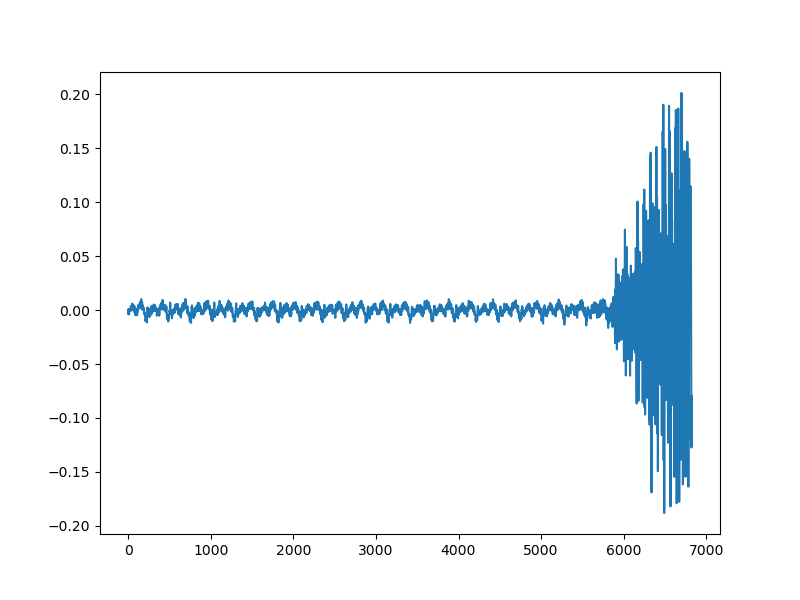

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

In [11]:
# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [12]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [13]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [14]:
### classic model

# class M5(nn.Module):
#     def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
#         super().__init__()
#         self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
#         self.bn1 = nn.BatchNorm1d(n_channel)
#         self.pool1 = nn.MaxPool1d(4)
#         self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
#         self.bn2 = nn.BatchNorm1d(n_channel)
#         self.pool2 = nn.MaxPool1d(4)
#         self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
#         self.bn3 = nn.BatchNorm1d(2 * n_channel)
#         self.pool3 = nn.MaxPool1d(4)
#         self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
#         self.bn4 = nn.BatchNorm1d(2 * n_channel)
#         self.pool4 = nn.MaxPool1d(4)
#         self.fc1 = nn.Linear(2 * n_channel, n_output)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(self.bn1(x))
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = F.relu(self.bn2(x))
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = F.relu(self.bn3(x))
#         x = self.pool3(x)
#         x = self.conv4(x)
#         x = F.relu(self.bn4(x))
#         x = self.pool4(x)
#         x = F.avg_pool1d(x, x.shape[-1])
#         x = x.permute(0, 2, 1)
#         x = self.fc1(x)
#         return F.log_softmax(x, dim=2)

In [15]:
class FGN_M5(nn.Module):
    
    # changes:
    # nn.Conv1d -> fgnl.FGN_Conv1d
    # added g to conv inputs and outputs
    # make sure you pass g through the same pooling steps as x
    
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.fgn_conv1 = fgnl.FGN_Conv1d(in_channels=n_input, out_channels=n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.fgn_conv2 = fgnl.FGN_Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fgn_conv3 = fgnl.FGN_Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.fgn_conv4 = fgnl.FGN_Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x, g = self.fgn_conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        g = self.pool1(g)
        x, g = self.fgn_conv2(x, g)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        g = self.pool2(g)
        x, g = self.fgn_conv3(x ,g)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        g = self.pool3(g)
        x, _ = self.fgn_conv4(x, g)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [16]:
model = FGN_M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:125: UserWarning: 
GeForce RTX 2080 Ti with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the GeForce RTX 2080 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


FGN_M5(
  (fgn_conv1): FGN_Conv1d(
    (Conv1d): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  )
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv2): FGN_Conv1d(
    (Conv1d): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  )
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv3): FGN_Conv1d(
    (Conv1d): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  )
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv4): FGN_Conv1d(
    (Conv1d): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  )
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): Ma

In [17]:
lmbda_sigma = 1e-5
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [18]:
# pre training model sigmas
fgnl.sigmas_loss(model, covar_type='sphere')

tensor([598.9500], device='cuda:0', grad_fn=<DivBackward0>)

In [19]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target) + lmbda_sigma*fgnl.sigmas_loss(model, covar_type='sphere')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [20]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [21]:
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.668873
Train Epoch: 1 [640/84843 (1%)]	Loss: 3.481808
Train Epoch: 1 [1280/84843 (2%)]	Loss: 3.371981
Train Epoch: 1 [1920/84843 (2%)]	Loss: 3.219701
Train Epoch: 1 [2560/84843 (3%)]	Loss: 3.111065
Train Epoch: 1 [3200/84843 (4%)]	Loss: 3.040591
Train Epoch: 1 [3840/84843 (5%)]	Loss: 2.736131
Train Epoch: 1 [4480/84843 (5%)]	Loss: 2.741158
Train Epoch: 1 [5120/84843 (6%)]	Loss: 2.606998
Train Epoch: 1 [5760/84843 (7%)]	Loss: 2.538143
Train Epoch: 1 [6400/84843 (8%)]	Loss: 2.509871
Train Epoch: 1 [7040/84843 (8%)]	Loss: 2.716952
Train Epoch: 1 [7680/84843 (9%)]	Loss: 2.493579
Train Epoch: 1 [8320/84843 (10%)]	Loss: 2.511074
Train Epoch: 1 [8960/84843 (11%)]	Loss: 2.549604
Train Epoch: 1 [9600/84843 (11%)]	Loss: 1.925741
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.381428
Train Epoch: 1 [10880/84843 (13%)]	Loss: 1.682406
Train Epoch: 1 [11520/84843 (14%)]	Loss: 2.410563
Train Epoch: 1 [12160/84843 (14%)]	Loss: 2.180352
Train Epoch: 1 [12800/84843 (15%)

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.204395
Train Epoch: 2 [21120/84843 (25%)]	Loss: 1.243618
Train Epoch: 2 [21760/84843 (26%)]	Loss: 0.883175
Train Epoch: 2 [22400/84843 (26%)]	Loss: 0.788468
Train Epoch: 2 [23040/84843 (27%)]	Loss: 0.797794
Train Epoch: 2 [23680/84843 (28%)]	Loss: 1.350888
Train Epoch: 2 [24320/84843 (29%)]	Loss: 1.096537
Train Epoch: 2 [24960/84843 (29%)]	Loss: 1.174446
Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.222481
Train Epoch: 2 [26240/84843 (31%)]	Loss: 0.798514
Train Epoch: 2 [26880/84843 (32%)]	Loss: 0.666985
Train Epoch: 2 [27520/84843 (32%)]	Loss: 0.944884
Train Epoch: 2 [28160/84843 (33%)]	Loss: 0.776617
Train Epoch: 2 [28800/84843 (34%)]	Loss: 0.873944
Train Epoch: 2 [29440/84843 (35%)]	Loss: 0.920089
Train Epoch: 2 [30080/84843 (35%)]	Loss: 0.941040
Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.547293
Train Epoch: 2 [31360/84843 (37%)]	Loss: 0.808360
Train Epoch: 2 [32000/84843 (38%)]	Loss: 0.800877
Train Epoch: 2 [32640/84843 (38%)]	Loss: 1.230525


Train Epoch: 3 [40320/84843 (48%)]	Loss: 1.226007
Train Epoch: 3 [40960/84843 (48%)]	Loss: 1.159626
Train Epoch: 3 [41600/84843 (49%)]	Loss: 1.082147
Train Epoch: 3 [42240/84843 (50%)]	Loss: 1.059609
Train Epoch: 3 [42880/84843 (51%)]	Loss: 0.820015
Train Epoch: 3 [43520/84843 (51%)]	Loss: 0.972181
Train Epoch: 3 [44160/84843 (52%)]	Loss: 1.257971
Train Epoch: 3 [44800/84843 (53%)]	Loss: 0.779539
Train Epoch: 3 [45440/84843 (54%)]	Loss: 0.674056
Train Epoch: 3 [46080/84843 (54%)]	Loss: 1.080295
Train Epoch: 3 [46720/84843 (55%)]	Loss: 0.718733
Train Epoch: 3 [47360/84843 (56%)]	Loss: 0.638164
Train Epoch: 3 [48000/84843 (57%)]	Loss: 0.691305
Train Epoch: 3 [48640/84843 (57%)]	Loss: 0.970841
Train Epoch: 3 [49280/84843 (58%)]	Loss: 0.979216
Train Epoch: 3 [49920/84843 (59%)]	Loss: 1.671426
Train Epoch: 3 [50560/84843 (60%)]	Loss: 0.791116
Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.679849
Train Epoch: 3 [51840/84843 (61%)]	Loss: 0.728074
Train Epoch: 3 [52480/84843 (62%)]	Loss: 1.131052


Train Epoch: 4 [60160/84843 (71%)]	Loss: 0.926077
Train Epoch: 4 [60800/84843 (72%)]	Loss: 0.702554
Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.657020
Train Epoch: 4 [62080/84843 (73%)]	Loss: 0.871183
Train Epoch: 4 [62720/84843 (74%)]	Loss: 0.501981
Train Epoch: 4 [63360/84843 (75%)]	Loss: 0.710906
Train Epoch: 4 [64000/84843 (75%)]	Loss: 0.806997
Train Epoch: 4 [64640/84843 (76%)]	Loss: 1.687180
Train Epoch: 4 [65280/84843 (77%)]	Loss: 1.045460
Train Epoch: 4 [65920/84843 (78%)]	Loss: 0.729473
Train Epoch: 4 [66560/84843 (78%)]	Loss: 1.295641
Train Epoch: 4 [67200/84843 (79%)]	Loss: 1.169794
Train Epoch: 4 [67840/84843 (80%)]	Loss: 1.058979
Train Epoch: 4 [68480/84843 (81%)]	Loss: 0.615886
Train Epoch: 4 [69120/84843 (81%)]	Loss: 0.712609
Train Epoch: 4 [69760/84843 (82%)]	Loss: 1.023827
Train Epoch: 4 [70400/84843 (83%)]	Loss: 0.837881
Train Epoch: 4 [71040/84843 (84%)]	Loss: 0.937151
Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.643641
Train Epoch: 4 [72320/84843 (85%)]	Loss: 1.168529


Train Epoch: 5 [80000/84843 (94%)]	Loss: 0.663340
Train Epoch: 5 [80640/84843 (95%)]	Loss: 0.739876
Train Epoch: 5 [81280/84843 (96%)]	Loss: 1.016158
Train Epoch: 5 [81920/84843 (97%)]	Loss: 0.592168
Train Epoch: 5 [82560/84843 (97%)]	Loss: 1.344651
Train Epoch: 5 [83200/84843 (98%)]	Loss: 0.726692
Train Epoch: 5 [83840/84843 (99%)]	Loss: 1.169541
Train Epoch: 5 [84480/84843 (100%)]	Loss: 0.842303

Test Epoch: 5	Accuracy: 8313/11005 (76%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.646940
Train Epoch: 6 [640/84843 (1%)]	Loss: 0.865964
Train Epoch: 6 [1280/84843 (2%)]	Loss: 0.758474
Train Epoch: 6 [1920/84843 (2%)]	Loss: 0.809389
Train Epoch: 6 [2560/84843 (3%)]	Loss: 0.956301
Train Epoch: 6 [3200/84843 (4%)]	Loss: 0.697860
Train Epoch: 6 [3840/84843 (5%)]	Loss: 0.818909
Train Epoch: 6 [4480/84843 (5%)]	Loss: 0.755524
Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.865839
Train Epoch: 6 [5760/84843 (7%)]	Loss: 0.930580
Train Epoch: 6 [6400/84843 (8%)]	Loss: 0.648392
Train Epoch: 6 [7040/84843 (8%)]

Train Epoch: 7 [14720/84843 (17%)]	Loss: 1.320641
Train Epoch: 7 [15360/84843 (18%)]	Loss: 1.246999
Train Epoch: 7 [16000/84843 (19%)]	Loss: 0.844280
Train Epoch: 7 [16640/84843 (20%)]	Loss: 0.549734
Train Epoch: 7 [17280/84843 (20%)]	Loss: 0.813602
Train Epoch: 7 [17920/84843 (21%)]	Loss: 0.593504
Train Epoch: 7 [18560/84843 (22%)]	Loss: 0.945379
Train Epoch: 7 [19200/84843 (23%)]	Loss: 0.551909
Train Epoch: 7 [19840/84843 (23%)]	Loss: 1.176375
Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.725897
Train Epoch: 7 [21120/84843 (25%)]	Loss: 0.815606
Train Epoch: 7 [21760/84843 (26%)]	Loss: 1.038602
Train Epoch: 7 [22400/84843 (26%)]	Loss: 1.235659
Train Epoch: 7 [23040/84843 (27%)]	Loss: 1.118493
Train Epoch: 7 [23680/84843 (28%)]	Loss: 1.609932
Train Epoch: 7 [24320/84843 (29%)]	Loss: 0.874529
Train Epoch: 7 [24960/84843 (29%)]	Loss: 0.704903
Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.671890
Train Epoch: 7 [26240/84843 (31%)]	Loss: 0.792875
Train Epoch: 7 [26880/84843 (32%)]	Loss: 0.702828


Train Epoch: 8 [34560/84843 (41%)]	Loss: 1.059857
Train Epoch: 8 [35200/84843 (41%)]	Loss: 1.324464
Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.993334
Train Epoch: 8 [36480/84843 (43%)]	Loss: 0.776760
Train Epoch: 8 [37120/84843 (44%)]	Loss: 0.725959
Train Epoch: 8 [37760/84843 (44%)]	Loss: 0.863935
Train Epoch: 8 [38400/84843 (45%)]	Loss: 0.792454
Train Epoch: 8 [39040/84843 (46%)]	Loss: 0.682941
Train Epoch: 8 [39680/84843 (47%)]	Loss: 0.754794
Train Epoch: 8 [40320/84843 (48%)]	Loss: 0.711874
Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.983542
Train Epoch: 8 [41600/84843 (49%)]	Loss: 1.103356
Train Epoch: 8 [42240/84843 (50%)]	Loss: 0.556510
Train Epoch: 8 [42880/84843 (51%)]	Loss: 1.117054
Train Epoch: 8 [43520/84843 (51%)]	Loss: 1.350990
Train Epoch: 8 [44160/84843 (52%)]	Loss: 1.565387
Train Epoch: 8 [44800/84843 (53%)]	Loss: 0.972143
Train Epoch: 8 [45440/84843 (54%)]	Loss: 0.949752
Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.798720
Train Epoch: 8 [46720/84843 (55%)]	Loss: 0.642702


Train Epoch: 9 [54400/84843 (64%)]	Loss: 0.691299
Train Epoch: 9 [55040/84843 (65%)]	Loss: 0.520467
Train Epoch: 9 [55680/84843 (66%)]	Loss: 0.733718
Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.930593
Train Epoch: 9 [56960/84843 (67%)]	Loss: 1.488512
Train Epoch: 9 [57600/84843 (68%)]	Loss: 0.954455
Train Epoch: 9 [58240/84843 (69%)]	Loss: 0.562073
Train Epoch: 9 [58880/84843 (69%)]	Loss: 0.946118
Train Epoch: 9 [59520/84843 (70%)]	Loss: 0.818551
Train Epoch: 9 [60160/84843 (71%)]	Loss: 1.009690
Train Epoch: 9 [60800/84843 (72%)]	Loss: 0.816974
Train Epoch: 9 [61440/84843 (72%)]	Loss: 1.020696
Train Epoch: 9 [62080/84843 (73%)]	Loss: 0.423361
Train Epoch: 9 [62720/84843 (74%)]	Loss: 0.582235
Train Epoch: 9 [63360/84843 (75%)]	Loss: 1.149590
Train Epoch: 9 [64000/84843 (75%)]	Loss: 0.751433
Train Epoch: 9 [64640/84843 (76%)]	Loss: 0.827541
Train Epoch: 9 [65280/84843 (77%)]	Loss: 0.887161
Train Epoch: 9 [65920/84843 (78%)]	Loss: 1.172417
Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.801804


Train Epoch: 10 [72960/84843 (86%)]	Loss: 1.134571
Train Epoch: 10 [73600/84843 (87%)]	Loss: 0.588851
Train Epoch: 10 [74240/84843 (87%)]	Loss: 0.487276
Train Epoch: 10 [74880/84843 (88%)]	Loss: 0.325109
Train Epoch: 10 [75520/84843 (89%)]	Loss: 1.021014
Train Epoch: 10 [76160/84843 (90%)]	Loss: 0.779140
Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.571057
Train Epoch: 10 [77440/84843 (91%)]	Loss: 0.915328
Train Epoch: 10 [78080/84843 (92%)]	Loss: 0.483533
Train Epoch: 10 [78720/84843 (93%)]	Loss: 0.775403
Train Epoch: 10 [79360/84843 (94%)]	Loss: 0.884056
Train Epoch: 10 [80000/84843 (94%)]	Loss: 0.698378
Train Epoch: 10 [80640/84843 (95%)]	Loss: 0.306167
Train Epoch: 10 [81280/84843 (96%)]	Loss: 0.593847
Train Epoch: 10 [81920/84843 (97%)]	Loss: 0.651764
Train Epoch: 10 [82560/84843 (97%)]	Loss: 0.823936
Train Epoch: 10 [83200/84843 (98%)]	Loss: 1.378380
Train Epoch: 10 [83840/84843 (99%)]	Loss: 0.692813
Train Epoch: 10 [84480/84843 (100%)]	Loss: 0.744760

Test Epoch: 10	Accuracy: 8370

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.532062
Train Epoch: 12 [5760/84843 (7%)]	Loss: 0.904767
Train Epoch: 12 [6400/84843 (8%)]	Loss: 0.650192
Train Epoch: 12 [7040/84843 (8%)]	Loss: 0.774058
Train Epoch: 12 [7680/84843 (9%)]	Loss: 1.086002
Train Epoch: 12 [8320/84843 (10%)]	Loss: 0.560571
Train Epoch: 12 [8960/84843 (11%)]	Loss: 1.419140
Train Epoch: 12 [9600/84843 (11%)]	Loss: 0.584889
Train Epoch: 12 [10240/84843 (12%)]	Loss: 1.005001
Train Epoch: 12 [10880/84843 (13%)]	Loss: 0.478130
Train Epoch: 12 [11520/84843 (14%)]	Loss: 0.639162
Train Epoch: 12 [12160/84843 (14%)]	Loss: 0.544374
Train Epoch: 12 [12800/84843 (15%)]	Loss: 0.589327
Train Epoch: 12 [13440/84843 (16%)]	Loss: 0.695442
Train Epoch: 12 [14080/84843 (17%)]	Loss: 0.766560
Train Epoch: 12 [14720/84843 (17%)]	Loss: 0.846215
Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.687923
Train Epoch: 12 [16000/84843 (19%)]	Loss: 0.680703
Train Epoch: 12 [16640/84843 (20%)]	Loss: 0.727736
Train Epoch: 12 [17280/84843 (20%)]	Loss: 1.

Train Epoch: 13 [23040/84843 (27%)]	Loss: 0.648350
Train Epoch: 13 [23680/84843 (28%)]	Loss: 0.486415
Train Epoch: 13 [24320/84843 (29%)]	Loss: 0.363884
Train Epoch: 13 [24960/84843 (29%)]	Loss: 0.562229
Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.841647
Train Epoch: 13 [26240/84843 (31%)]	Loss: 0.547269
Train Epoch: 13 [26880/84843 (32%)]	Loss: 0.836971
Train Epoch: 13 [27520/84843 (32%)]	Loss: 0.499975
Train Epoch: 13 [28160/84843 (33%)]	Loss: 1.040974
Train Epoch: 13 [28800/84843 (34%)]	Loss: 0.631002
Train Epoch: 13 [29440/84843 (35%)]	Loss: 0.555106
Train Epoch: 13 [30080/84843 (35%)]	Loss: 0.624687
Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.890661
Train Epoch: 13 [31360/84843 (37%)]	Loss: 0.703688
Train Epoch: 13 [32000/84843 (38%)]	Loss: 1.227561
Train Epoch: 13 [32640/84843 (38%)]	Loss: 1.003301
Train Epoch: 13 [33280/84843 (39%)]	Loss: 0.619144
Train Epoch: 13 [33920/84843 (40%)]	Loss: 0.710517
Train Epoch: 13 [34560/84843 (41%)]	Loss: 0.671678
Train Epoch: 13 [35200/84843 (4

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.513732
Train Epoch: 14 [41600/84843 (49%)]	Loss: 0.881846
Train Epoch: 14 [42240/84843 (50%)]	Loss: 0.688294
Train Epoch: 14 [42880/84843 (51%)]	Loss: 1.060796
Train Epoch: 14 [43520/84843 (51%)]	Loss: 0.687228
Train Epoch: 14 [44160/84843 (52%)]	Loss: 0.947039
Train Epoch: 14 [44800/84843 (53%)]	Loss: 0.656107
Train Epoch: 14 [45440/84843 (54%)]	Loss: 0.494172
Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.767515
Train Epoch: 14 [46720/84843 (55%)]	Loss: 1.166568
Train Epoch: 14 [47360/84843 (56%)]	Loss: 0.653296
Train Epoch: 14 [48000/84843 (57%)]	Loss: 0.695787
Train Epoch: 14 [48640/84843 (57%)]	Loss: 1.068094
Train Epoch: 14 [49280/84843 (58%)]	Loss: 0.835499
Train Epoch: 14 [49920/84843 (59%)]	Loss: 0.475468
Train Epoch: 14 [50560/84843 (60%)]	Loss: 0.586948
Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.710495
Train Epoch: 14 [51840/84843 (61%)]	Loss: 0.379100
Train Epoch: 14 [52480/84843 (62%)]	Loss: 0.732642
Train Epoch: 14 [53120/84843 (6

Train Epoch: 15 [58880/84843 (69%)]	Loss: 0.801886
Train Epoch: 15 [59520/84843 (70%)]	Loss: 0.707909
Train Epoch: 15 [60160/84843 (71%)]	Loss: 0.500663
Train Epoch: 15 [60800/84843 (72%)]	Loss: 0.670750
Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.608446
Train Epoch: 15 [62080/84843 (73%)]	Loss: 0.489268
Train Epoch: 15 [62720/84843 (74%)]	Loss: 0.893897
Train Epoch: 15 [63360/84843 (75%)]	Loss: 0.744460
Train Epoch: 15 [64000/84843 (75%)]	Loss: 0.613440
Train Epoch: 15 [64640/84843 (76%)]	Loss: 1.034032
Train Epoch: 15 [65280/84843 (77%)]	Loss: 0.811003
Train Epoch: 15 [65920/84843 (78%)]	Loss: 0.505527
Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.474182
Train Epoch: 15 [67200/84843 (79%)]	Loss: 0.617534
Train Epoch: 15 [67840/84843 (80%)]	Loss: 0.301690
Train Epoch: 15 [68480/84843 (81%)]	Loss: 0.551445
Train Epoch: 15 [69120/84843 (81%)]	Loss: 0.344547
Train Epoch: 15 [69760/84843 (82%)]	Loss: 0.884936
Train Epoch: 15 [70400/84843 (83%)]	Loss: 0.402309
Train Epoch: 15 [71040/84843 (8

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.898264
Train Epoch: 16 [77440/84843 (91%)]	Loss: 0.925824
Train Epoch: 16 [78080/84843 (92%)]	Loss: 1.132128
Train Epoch: 16 [78720/84843 (93%)]	Loss: 1.268849
Train Epoch: 16 [79360/84843 (94%)]	Loss: 0.996776
Train Epoch: 16 [80000/84843 (94%)]	Loss: 0.926844
Train Epoch: 16 [80640/84843 (95%)]	Loss: 1.032625
Train Epoch: 16 [81280/84843 (96%)]	Loss: 0.992241
Train Epoch: 16 [81920/84843 (97%)]	Loss: 0.755579
Train Epoch: 16 [82560/84843 (97%)]	Loss: 1.003126
Train Epoch: 16 [83200/84843 (98%)]	Loss: 0.679140
Train Epoch: 16 [83840/84843 (99%)]	Loss: 0.956595
Train Epoch: 16 [84480/84843 (100%)]	Loss: 0.439146

Test Epoch: 16	Accuracy: 8474/11005 (77%)

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.801551
Train Epoch: 17 [640/84843 (1%)]	Loss: 0.514323
Train Epoch: 17 [1280/84843 (2%)]	Loss: 1.062652
Train Epoch: 17 [1920/84843 (2%)]	Loss: 0.320381
Train Epoch: 17 [2560/84843 (3%)]	Loss: 0.832179
Train Epoch: 17 [3200/84843 (4%)]	Loss: 0.726088
Tr

Train Epoch: 18 [9600/84843 (11%)]	Loss: 0.762945
Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.824835
Train Epoch: 18 [10880/84843 (13%)]	Loss: 1.027573
Train Epoch: 18 [11520/84843 (14%)]	Loss: 0.703780
Train Epoch: 18 [12160/84843 (14%)]	Loss: 1.048609
Train Epoch: 18 [12800/84843 (15%)]	Loss: 1.047978
Train Epoch: 18 [13440/84843 (16%)]	Loss: 0.560361
Train Epoch: 18 [14080/84843 (17%)]	Loss: 0.748627
Train Epoch: 18 [14720/84843 (17%)]	Loss: 0.546392
Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.712944
Train Epoch: 18 [16000/84843 (19%)]	Loss: 0.762196
Train Epoch: 18 [16640/84843 (20%)]	Loss: 0.973961
Train Epoch: 18 [17280/84843 (20%)]	Loss: 0.641537
Train Epoch: 18 [17920/84843 (21%)]	Loss: 0.923236
Train Epoch: 18 [18560/84843 (22%)]	Loss: 0.997885
Train Epoch: 18 [19200/84843 (23%)]	Loss: 0.944590
Train Epoch: 18 [19840/84843 (23%)]	Loss: 1.006884
Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.693071
Train Epoch: 18 [21120/84843 (25%)]	Loss: 1.298788
Train Epoch: 18 [21760/84843 (26

Train Epoch: 19 [27520/84843 (32%)]	Loss: 0.701141
Train Epoch: 19 [28160/84843 (33%)]	Loss: 0.567744
Train Epoch: 19 [28800/84843 (34%)]	Loss: 0.698017
Train Epoch: 19 [29440/84843 (35%)]	Loss: 0.896352
Train Epoch: 19 [30080/84843 (35%)]	Loss: 0.638242
Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.749329
Train Epoch: 19 [31360/84843 (37%)]	Loss: 0.749485
Train Epoch: 19 [32000/84843 (38%)]	Loss: 1.354214
Train Epoch: 19 [32640/84843 (38%)]	Loss: 0.808642
Train Epoch: 19 [33280/84843 (39%)]	Loss: 0.359148
Train Epoch: 19 [33920/84843 (40%)]	Loss: 0.753734
Train Epoch: 19 [34560/84843 (41%)]	Loss: 0.901130
Train Epoch: 19 [35200/84843 (41%)]	Loss: 0.492390
Train Epoch: 19 [35840/84843 (42%)]	Loss: 1.020408
Train Epoch: 19 [36480/84843 (43%)]	Loss: 1.061042
Train Epoch: 19 [37120/84843 (44%)]	Loss: 1.165920
Train Epoch: 19 [37760/84843 (44%)]	Loss: 0.699112
Train Epoch: 19 [38400/84843 (45%)]	Loss: 0.262811
Train Epoch: 19 [39040/84843 (46%)]	Loss: 1.008577
Train Epoch: 19 [39680/84843 (4

Train Epoch: 20 [45440/84843 (54%)]	Loss: 0.806012
Train Epoch: 20 [46080/84843 (54%)]	Loss: 1.022321
Train Epoch: 20 [46720/84843 (55%)]	Loss: 0.819144
Train Epoch: 20 [47360/84843 (56%)]	Loss: 0.586106
Train Epoch: 20 [48000/84843 (57%)]	Loss: 0.522342
Train Epoch: 20 [48640/84843 (57%)]	Loss: 1.137829
Train Epoch: 20 [49280/84843 (58%)]	Loss: 0.977054
Train Epoch: 20 [49920/84843 (59%)]	Loss: 0.711265
Train Epoch: 20 [50560/84843 (60%)]	Loss: 0.648710
Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.561903
Train Epoch: 20 [51840/84843 (61%)]	Loss: 0.848533
Train Epoch: 20 [52480/84843 (62%)]	Loss: 0.417453
Train Epoch: 20 [53120/84843 (63%)]	Loss: 0.677032
Train Epoch: 20 [53760/84843 (63%)]	Loss: 0.801011
Train Epoch: 20 [54400/84843 (64%)]	Loss: 0.843385
Train Epoch: 20 [55040/84843 (65%)]	Loss: 0.899711
Train Epoch: 20 [55680/84843 (66%)]	Loss: 0.596100
Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.669938
Train Epoch: 20 [56960/84843 (67%)]	Loss: 1.370692
Train Epoch: 20 [57600/84843 (6

Train Epoch: 21 [63360/84843 (75%)]	Loss: 0.374852
Train Epoch: 21 [64000/84843 (75%)]	Loss: 0.407925
Train Epoch: 21 [64640/84843 (76%)]	Loss: 0.538748
Train Epoch: 21 [65280/84843 (77%)]	Loss: 0.700287
Train Epoch: 21 [65920/84843 (78%)]	Loss: 0.735896
Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.372640
Train Epoch: 21 [67200/84843 (79%)]	Loss: 0.750318
Train Epoch: 21 [67840/84843 (80%)]	Loss: 0.324763
Train Epoch: 21 [68480/84843 (81%)]	Loss: 0.581533
Train Epoch: 21 [69120/84843 (81%)]	Loss: 0.657786
Train Epoch: 21 [69760/84843 (82%)]	Loss: 0.678573
Train Epoch: 21 [70400/84843 (83%)]	Loss: 0.467192
Train Epoch: 21 [71040/84843 (84%)]	Loss: 0.631935
Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.460943
Train Epoch: 21 [72320/84843 (85%)]	Loss: 0.398083
Train Epoch: 21 [72960/84843 (86%)]	Loss: 0.602714
Train Epoch: 21 [73600/84843 (87%)]	Loss: 0.401829
Train Epoch: 21 [74240/84843 (87%)]	Loss: 0.500786
Train Epoch: 21 [74880/84843 (88%)]	Loss: 0.421353
Train Epoch: 21 [75520/84843 (8

In [22]:
test(model, epoch)


Test Epoch: 21	Accuracy: 9244/11005 (84%)



In [23]:
# compute confusion matrix

<IPython.core.display.Javascript object>


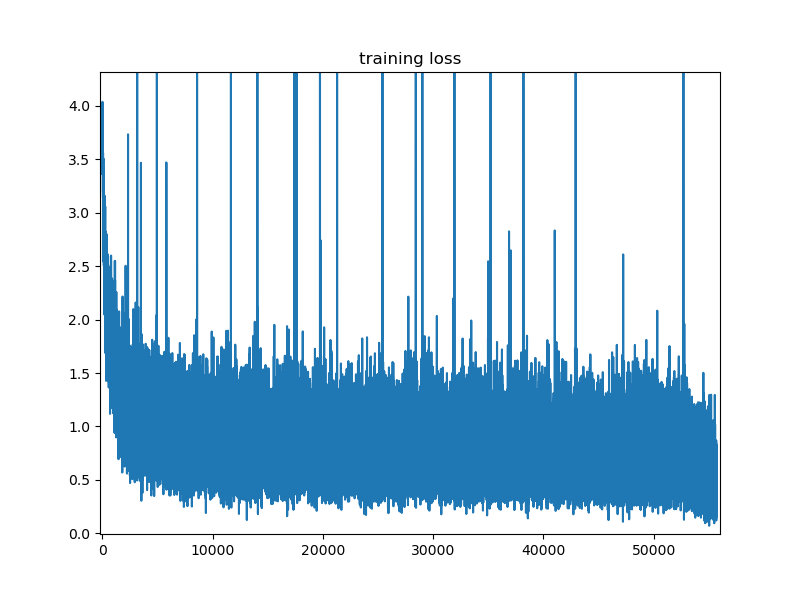

In [24]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")
plt.show()

In [25]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [26]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
#     tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: four. Predicted: zero.


In [27]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_loader.dataset):
    try:
        output = predict(waveform)
        if output != utterance:
            ipd.Audio(waveform.numpy(), rate=sample_rate)
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
            break
        else:
            print("All examples in this dataset were correctly classified!")
            print("In this case, let's just look at the last data point")
            ipd.Audio(waveform.numpy(), rate=sample_rate)
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
    except:
        # model fails on short wav because of no padding
        print('{} failed'.format(i))
        print(waveform.size())

Data point #0. Expected: right. Predicted: left.


In [28]:
# ### save model
# model_name = 'sample_FGN_model_SPEECHCOMMANDS'
# save_path = '../Experiments/sample_SPEECHCOMMANDS_models/'
# print('Saving trained model {} in {}'.format(model_name, save_path))

# # save model entirely
# torch.save(model, save_path+model_name+'_full.pth')

# # save model weights
# torch.save(model.state_dict(), save_path+model_name+'_state_dict.pth')



Saving trained model sample_FGN_model_SPEECHCOMMANDS in ../Experiments/sample_SPEECHCOMMANDS_models/


In [29]:
# check model trained for 10 epochs

In [30]:
model_name = 'sample_FGN_model_SPEECHCOMMANDS'
save_path = '../Experiments/sample_SPEECHCOMMANDS_models/'

model.load_state_dict(torch.load(save_path+model_name+'_state_dict.pth'))

<All keys matched successfully>

In [31]:
fgnl.sigmas_loss(model, covar_type='sphere')

tensor([91.1157], device='cuda:0', grad_fn=<DivBackward0>)

In [32]:
test(model, epoch)


Test Epoch: 21	Accuracy: 9244/11005 (84%)



In [33]:
model.state_dict()

OrderedDict([('fgn_conv1.centers',
              tensor([[[ 3.3424e-01, -4.5260e-02, -4.4573e-03,  ..., -3.7155e-02,
                        -2.5887e-02,  1.8995e-02],
                       [-6.4095e-02, -4.6157e-01, -4.1642e-02,  ..., -4.4547e-01,
                        -2.1391e-01, -7.2669e-02],
                       [ 4.8288e-02,  1.1523e-01,  1.5676e-01,  ...,  2.9031e-02,
                        -2.7300e-03, -1.1804e-02],
                       ...,
                       [-3.4916e-02,  3.7632e-02, -1.8283e-03,  ..., -4.6199e-05,
                        -1.6253e-03, -4.4822e-03],
                       [ 7.3770e-03,  2.6562e-02,  6.0272e-02,  ...,  2.1814e-02,
                        -4.6841e-02, -6.0776e-02],
                       [ 4.5305e-02, -4.5754e-02, -1.3407e-02,  ..., -4.2920e-03,
                         5.3504e-03,  1.6264e-02]]], device='cuda:0')),
             ('fgn_conv1.inv_covars',
              tensor([[ 0.4141,  0.2194,  0.1128,  ...,  0.4218,  0.1076,  0.114